In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
# from keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [2]:
BASE_DIR = '../input/utkface-new/UTKFace/'


In [3]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26,0
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22,1
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21,1
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28,0
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17,1


In [5]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

In [6]:
df

,image,age,gender
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26,0
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22,1
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21,1
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28,0
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17,1
...,...,...,...
23703,../input/utkface-new/UTKFace/41_0_0_2017010901...,41,0
23704,../input/utkface-new/UTKFace/42_0_0_2017011718...,42,0
23705,../input/utkface-new/UTKFace/2_0_2_20161219221...,2,0
23706,../input/utkface-new/UTKFace/65_1_0_2017011018...,65,1


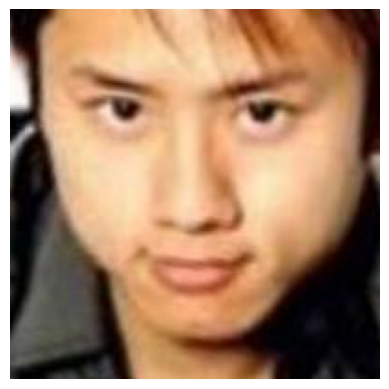

In [7]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<AxesSubplot:xlabel='age', ylabel='Density'>

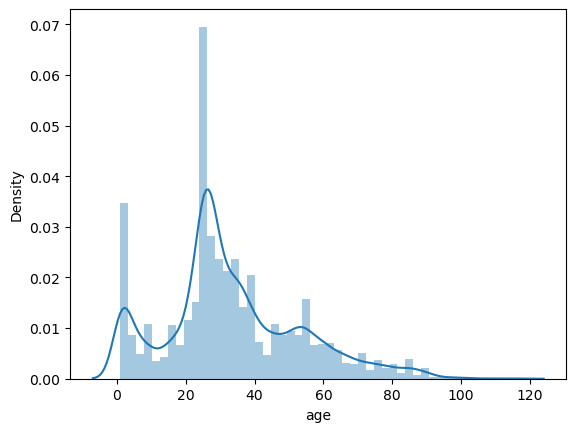

In [8]:
sns.distplot(df['age'])


<AxesSubplot:xlabel='gender', ylabel='count'>

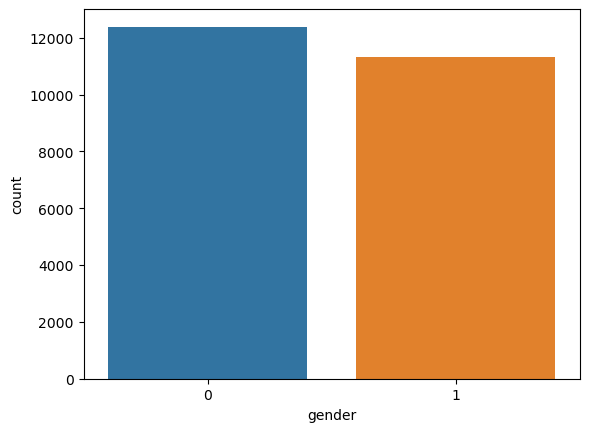

In [9]:
sns.countplot(x='gender',data=df)


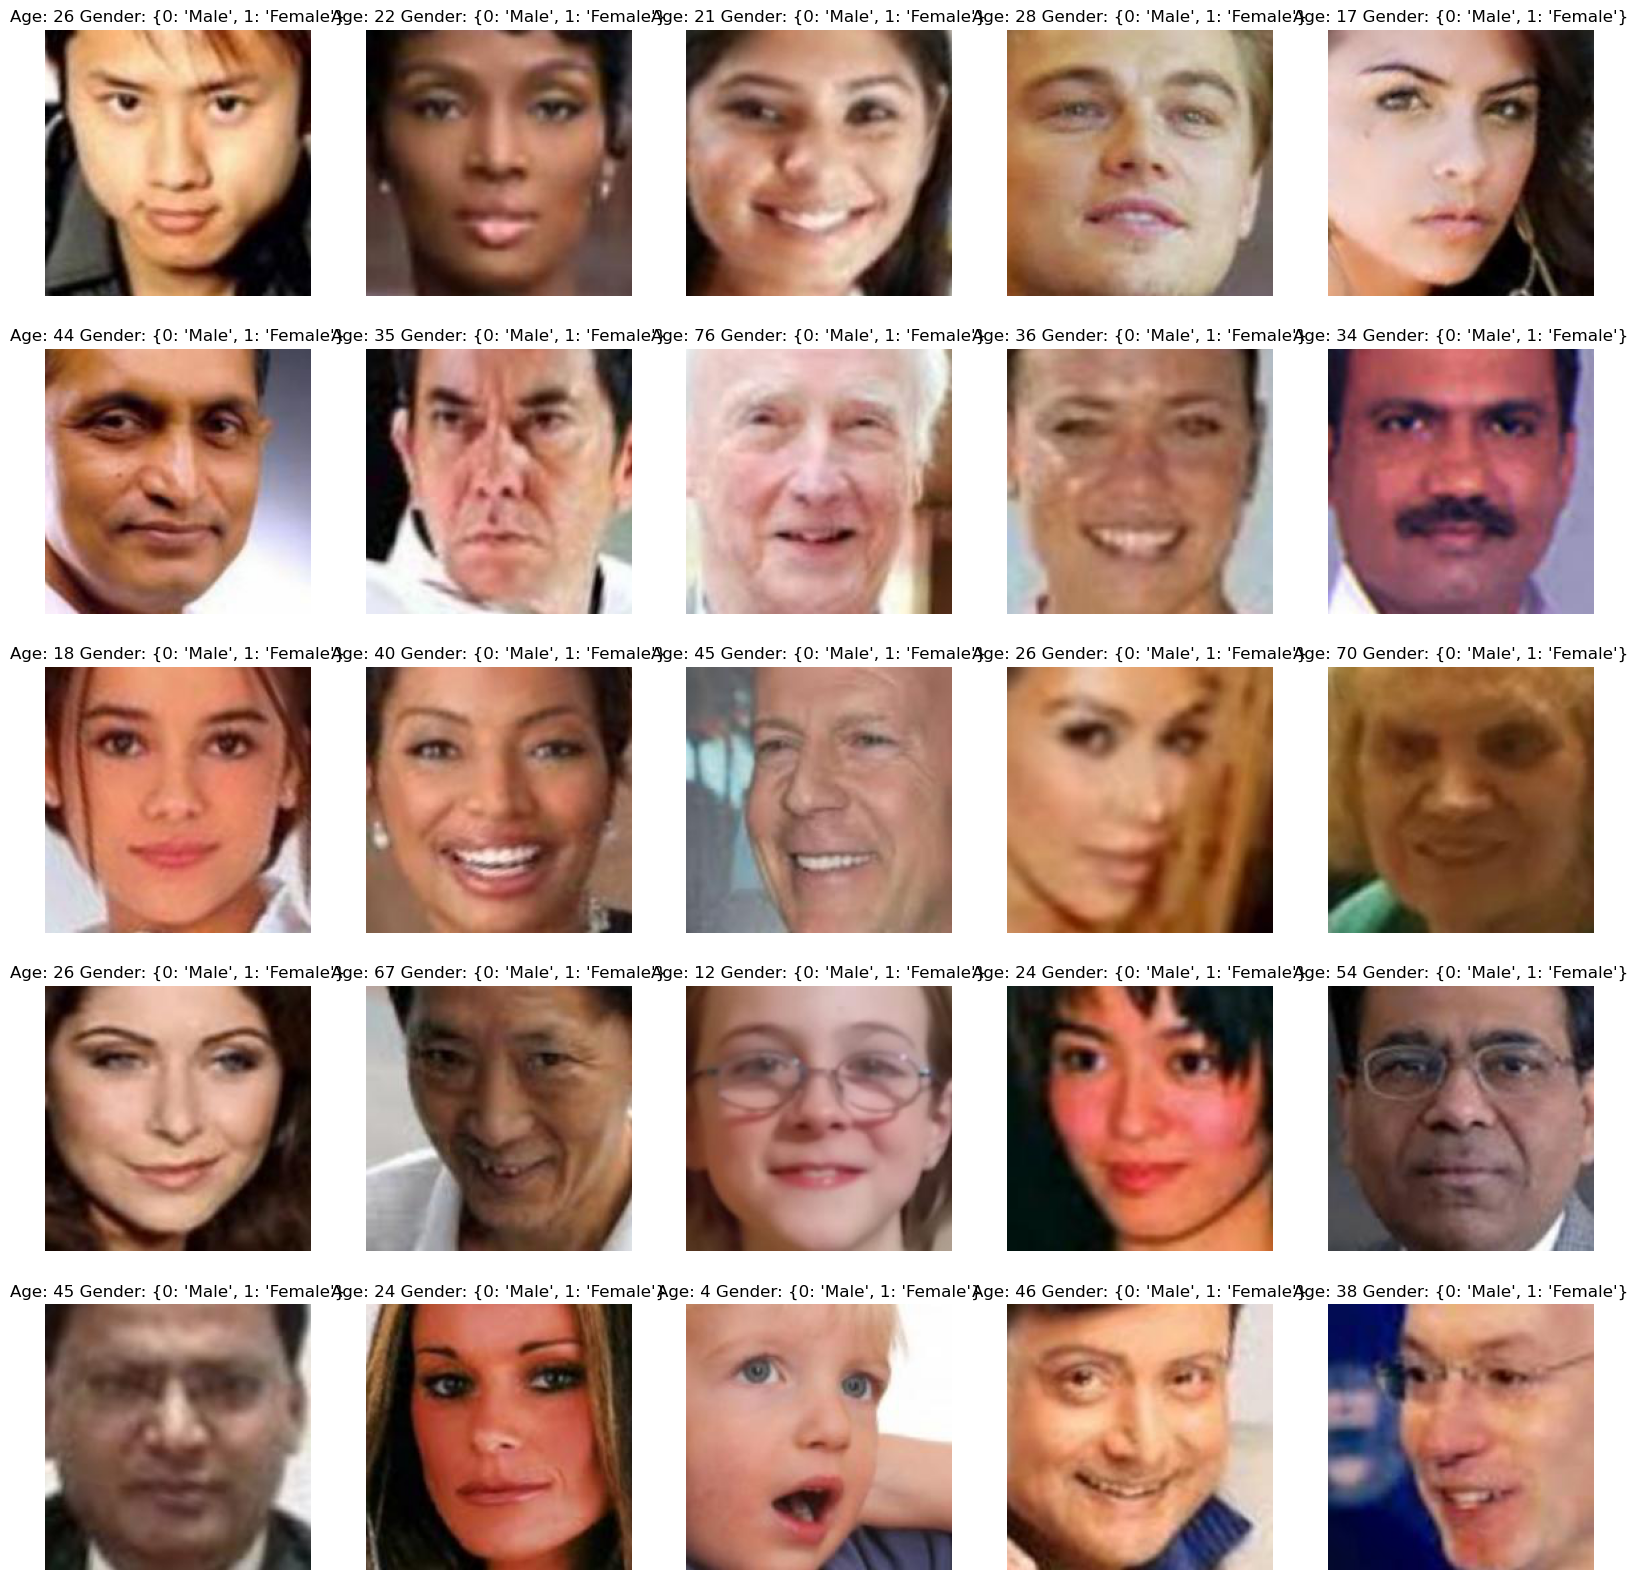

In [10]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict}")
    plt.axis('off')

In [11]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [12]:
X = extract_features(df['image'])


  0%|          | 0/23708 [00:00<?, ?it/s]

In [13]:
X.shape

(23708, 128, 128, 1)

In [14]:
# normalize the images
X = X/255.0

In [15]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [16]:
input_shape = (128, 128, 1)


In [17]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

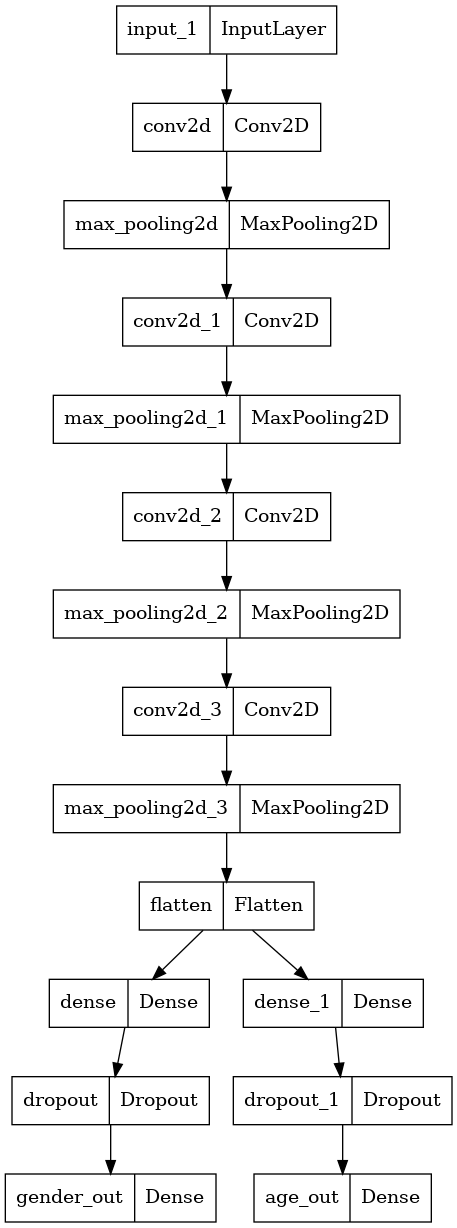

In [18]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [27]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=50, validation_split=0.2)


Epoch 1/50
593/593 [==============================] - 9s 15ms/step - loss: 7.6256 - gender_out_loss: 0.2969 - age_out_loss: 7.3288 - gender_out_accuracy: 0.8669 - age_out_accuracy: 0.0071 - val_loss: 7.2404 - val_gender_out_loss: 0.2941 - val_age_out_loss: 6.9463 - val_gender_out_accuracy: 0.8659 - val_age_out_accuracy: 0.0061
Epoch 2/50
593/593 [==============================] - 9s 15ms/step - loss: 7.2294 - gender_out_loss: 0.2794 - age_out_loss: 6.9501 - gender_out_accuracy: 0.8787 - age_out_accuracy: 0.0061 - val_loss: 7.5484 - val_gender_out_loss: 0.2928 - val_age_out_loss: 7.2557 - val_gender_out_accuracy: 0.8663 - val_age_out_accuracy: 0.0105
Epoch 3/50
593/593 [==============================] - 9s 15ms/step - loss: 6.9213 - gender_out_loss: 0.2652 - age_out_loss: 6.6561 - gender_out_accuracy: 0.8854 - age_out_accuracy: 0.0062 - val_loss: 7.1277 - val_gender_out_loss: 0.2708 - val_age_out_loss: 6.8569 - val_gender_out_accuracy: 0.8798 - val_age_out_accuracy: 0.0040
Epoch 4/50
59

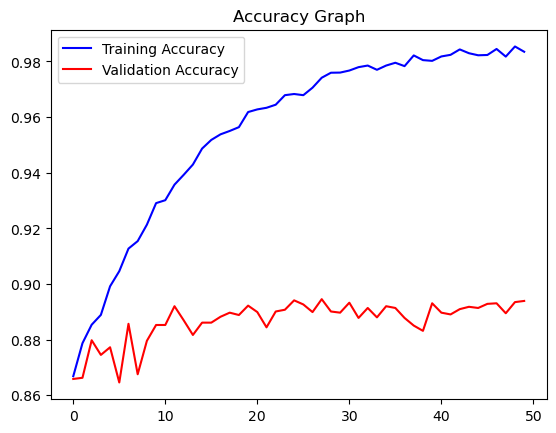

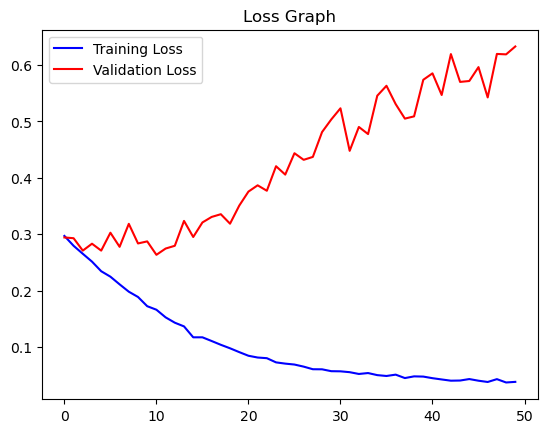

In [28]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

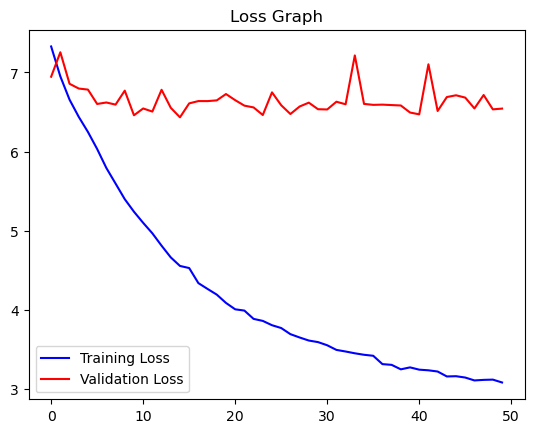

In [29]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Female Original Age: 3
1/1 [==============================] - 0s 23ms/step
Predicted Gender: Female Predicted Age: 3


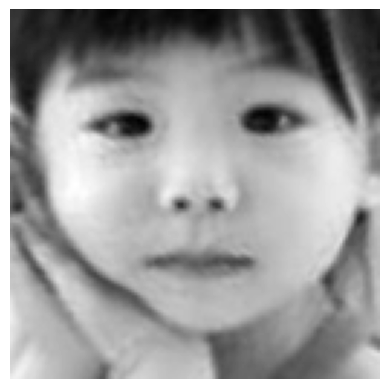

In [30]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 26
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male Predicted Age: 26


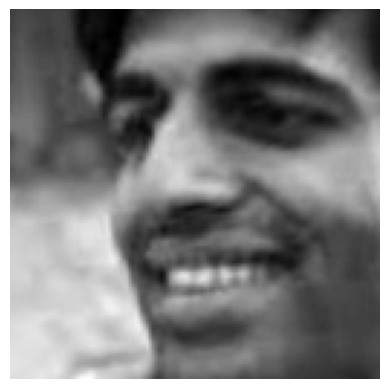

In [53]:
image_index = 3589
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 22
1/1 [==============================] - 0s 23ms/step
Predicted Gender: Female Predicted Age: 26


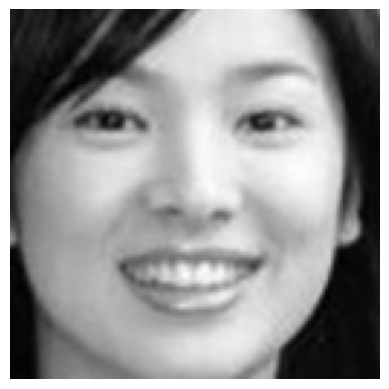

In [33]:
image_index = 10560
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 66
1/1 [==============================] - 0s 28ms/step
Predicted Gender: Male Predicted Age: 76


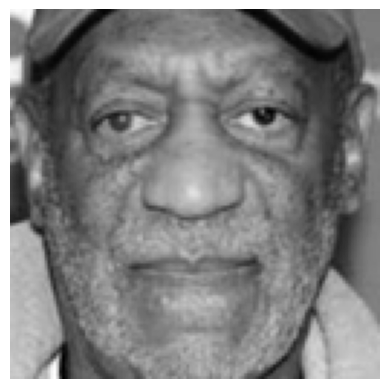

In [47]:
image_index = 23707
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 30
1/1 [==============================] - 0s 37ms/step
Predicted Gender: Male Predicted Age: 28


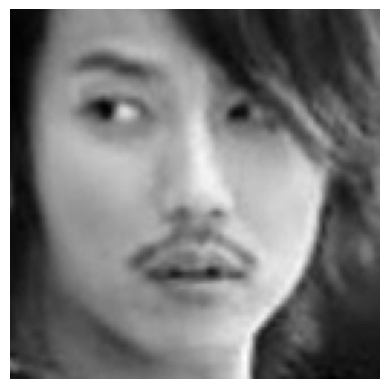

In [56]:
image_index = 7590
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128),cmap='gray');